<a href="https://colab.research.google.com/github/KutaySekerci/NLP/blob/main/NLP_Kutay%C5%9EEKERC%C4%B0_210229003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1- Gerekli Bileşenlerin İndirilmesi**


In [ ]:
# Veri seti
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format
# Kütüphaneler
!pip install datasets
!pip install transformers

Dataset URL: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format
License(s): world-bank
 74% 19.0M/25.7M [00:00<00:00, 98.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 97.1MB/s]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you 

**2- Gerekli Kütüphanelerin İmport Edilmesi**


In [ ]:
import zipfile
import os
import pandas as pd
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import logging
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset






[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**3- Veri Setinin İşlenmesi**

CSV files: ['Test.csv', 'Valid.csv', 'Train.csv']
Dimensions of the merged dataset: (50000, 2)
Columns: Index(['text', 'label'], dtype='object')


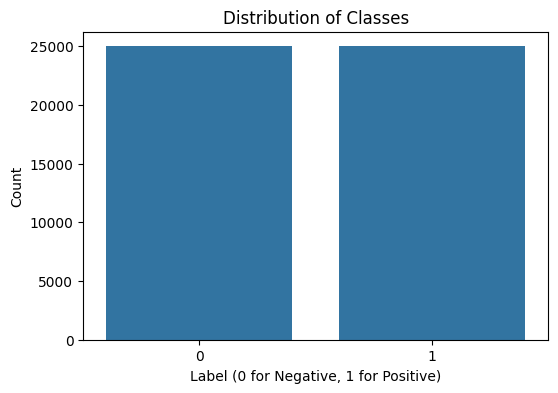

Missing Values:
text     0
label    0
dtype: int64
Statistical Summary:
              label
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000

Sample Comments:
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0


In [ ]:
with zipfile.ZipFile("imdb-dataset-sentiment-analysis-in-csv-format.zip", "r") as zip_ref:
    zip_ref.extractall("imdb_sentiment")

csv_files = [f for f in os.listdir("imdb_sentiment") if f.endswith('.csv')]
print("CSV files:", csv_files)

dataframe = []
for csv_file in csv_files:
    df = pd.read_csv(f"imdb_sentiment/{csv_file}")
    dataframe.append(df)

final_data = pd.concat(dataframe, ignore_index=True)

print(f"Dimensions of the merged dataset: {final_data.shape}")
print("Columns:", final_data.columns)

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=final_data)
plt.title("Distribution of Classes")
plt.xlabel("Label (0 for Negative, 1 for Positive)")
plt.ylabel("Count")
plt.show()

print("Missing Values:")
print(final_data.isnull().sum())

print("Statistical Summary:")
print(final_data.describe())

print("\nSample Comments:")
print(final_data.head())




**4- Veri Setinde Bulunan Büyük Harflerin Küçük Harflerle Değiştirilmesi**

In [ ]:
def convert_text_to_lowercase(df, column_name):

    df[column_name] = df[column_name].str.lower()
    return df

final_data = convert_text_to_lowercase(final_data, 'text')

print(final_data.head())

                                                text  label
0  i always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(dir-steve ...      0
2  this movie was so poorly written and directed ...      0
3  the most interesting thing about miryang (secr...      1
4  when i first read about "berlin am meer" i did...      0


**5- Veri Setindeki Noktalama İşaretlerini Kaldırma**

In [ ]:
def remove_punctuation(df, column_name):

    df[column_name] = df[column_name].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)
    return df

final_data = remove_punctuation(final_data, 'text')

print(final_data.head())


                                                text  label
0  i always wrote this series off as being a comp...      0
1  1st watched 1272002  3 out of 10dirsteve purce...      0
2  this movie was so poorly written and directed ...      0
3  the most interesting thing about miryang secre...      1
4  when i first read about berlin am meer i didnt...      0


 **6- Veri Setindeki StopWord'lerin Kaldırılması**

In [ ]:
def remove_stopwords(df, column_name):

    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        if isinstance(text, str):
            words = word_tokenize(text)
            return ' '.join([word for word in words if word.lower() not in stop_words])
        return text

    df[column_name] = df[column_name].apply(clean_text)
    return df

final_data = remove_stopwords(final_data, 'text')

print(final_data.head())


                                                text  label
0  always wrote series complete stinkfest jim bel...      0
1  1st watched 1272002 3 10dirsteve purcell typic...      0
2  movie poorly written directed fell asleep 30 m...      0
3  interesting thing miryang secret sunshine acto...      1
4  first read berlin meer didnt expect much thoug...      0


**7- Tokenizasyon	ve	Lemmatizasyon İşlemi**

In [ ]:
def tokenize_and_lemmatize(df, column_name):

    lemmatizer = WordNetLemmatizer()

    def lemmatize_text(text):
        if isinstance(text, str):
            words = word_tokenize(text)
            return ' '.join([lemmatizer.lemmatize(word) for word in words])
        return text

    df[column_name] = df[column_name].apply(lemmatize_text)
    return df
# 'text' sütunundaki metinleri tokenize edip lemmatize et
final_data = tokenize_and_lemmatize(final_data, 'text')

print(final_data.head())

                                                text  label
0  always wrote series complete stinkfest jim bel...      0
1  1st watched 1272002 3 10dirsteve purcell typic...      0
2  movie poorly written directed fell asleep 30 m...      0
3  interesting thing miryang secret sunshine acto...      1
4  first read berlin meer didnt expect much thoug...      0


**8- Veriyi Test ve Train Olarak Ayırma**

In [ ]:
# Text ve label sütunlarını kontrol edin
print(final_data.head())

# Eğitim ve test setlerine ayır
X = final_data['text']
y = final_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


                                                text  label
0  always wrote series complete stinkfest jim bel...      0
1  1st watched 1272002 3 10dirsteve purcell typic...      0
2  movie poorly written directed fell asleep 30 m...      0
3  interesting thing miryang secret sunshine acto...      1
4  first read berlin meer didnt expect much thoug...      0


**9- TFIDF ile Metni Vektörleştirme**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

**10- Logistic Regresyon ile Sınıflandırma ve Sonuç Değerlendirimi**

In [ ]:
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_tfidf, y_train)
log_reg_y_pred = log_reg_model.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_y_pred))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_y_pred))

Logistic Regression Accuracy: 0.8908
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5011
           1       0.88      0.90      0.89      4989

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**12- Naive Bayes ile Sınıflandırma ve Sonuç Değerlendirimi**

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8563
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5011
           1       0.86      0.86      0.86      4989

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



**12- SVM(Support Vector Machine) ile Sınıflandırma ve Sonuç Değerlendirimi**

In [ ]:

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8888
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      5011
           1       0.88      0.89      0.89      4989

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**13- DistilBERT ile Sınıflandırma ve Sonuç Değerlendirimi**

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("wandb").setLevel(logging.ERROR)

data = final_data[['text', 'label']].rename(columns={'text': 'text', 'label': 'label'})
data['label'] = data['label'].map({1: 1, 0: 0})
data = data.dropna()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_texts, 'label': train_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_texts, 'label': test_labels}))
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids
print(classification_report(true_labels, pred_labels))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5086, 'grad_norm': 14.206982612609863, 'learning_rate': 4.8e-05, 'epoch': 0.04}
{'loss': 0.3996, 'grad_norm': 15.368160247802734, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.08}
{'loss': 0.3704, 'grad_norm': 23.30327796936035, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.12}
{'loss': 0.349, 'grad_norm': 26.152881622314453, 'learning_rate': 4.2e-05, 'epoch': 0.16}
{'loss': 0.3766, 'grad_norm': 27.11261749267578, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 0.339, 'grad_norm': 12.500465393066406, 'learning_rate': 3.8e-05, 'epoch': 0.24}
{'loss': 0.3629, 'grad_norm': 12.286124229431152, 'learning_rate': 3.6e-05, 'epoch': 0.28}
{'loss': 0.331, 'grad_norm': 19.93561363220215, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.32}
{'loss': 0.3367, 'grad_norm': 23.73162078857422, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.36}
{'loss': 0.3405, 'grad_norm': 11.147430419921875, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.3097, 'grad_norm': 19.39774703979

**14- Logistic Regresyon ile Sınıflandırma Raporu ve Karmaşıklık Matrisi**

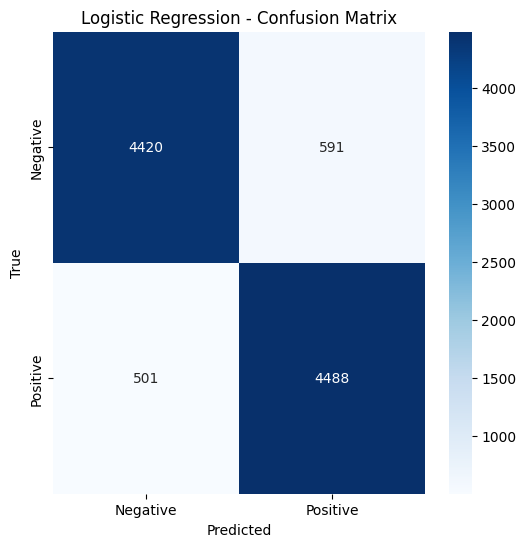

{'0': {'precision': 0.898191424507214, 'recall': 0.8820594691678307, 'f1-score': 0.8900523560209425, 'support': 5011.0}, '1': {'precision': 0.8836385115180153, 'recall': 0.899579073962718, 'f1-score': 0.8915375446960667, 'support': 4989.0}, 'accuracy': 0.8908, 'macro avg': {'precision': 0.8909149680126147, 'recall': 0.8908192715652743, 'f1-score': 0.8907949503585046, 'support': 10000.0}, 'weighted avg': {'precision': 0.8909309762169029, 'recall': 0.8908, 'f1-score': 0.890793316650962, 'support': 10000.0}}


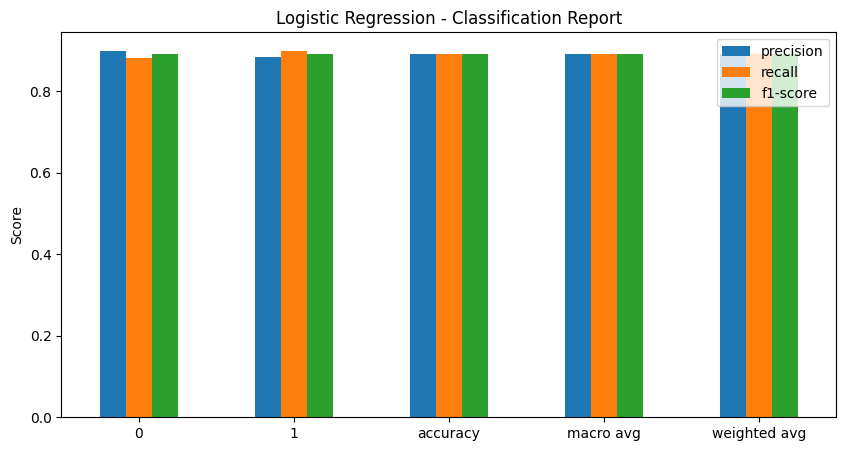

In [ ]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_classification_report(report_dict, model_name):
    metrics = ['precision', 'recall', 'f1-score']
    report_df = pd.DataFrame(report_dict).transpose()

    if all(metric in report_df.columns for metric in metrics):
        plt.figure(figsize=(10, 5))
        report_df[metrics].plot(kind='bar', title=f"{model_name} - Classification Report", ax=plt.gca())
        plt.xticks(rotation=0)
        plt.ylabel('Score')
        plt.show()
    else:
        print("Gerekli metrikler bulunamadı: precision, recall, f1-score")

log_reg_conf_matrix = confusion_matrix(y_test, log_reg_y_pred)
plot_confusion_matrix(log_reg_conf_matrix, "Logistic Regression")

log_reg_report = classification_report(y_test, log_reg_y_pred, output_dict=True)
print(log_reg_report)
log_reg_df = pd.DataFrame(log_reg_report).transpose()
plot_classification_report(log_reg_report, "Logistic Regression")


**15- DistilBERT ile Sınıflandırma Raporu ve Karmaşıklık Matrisi**

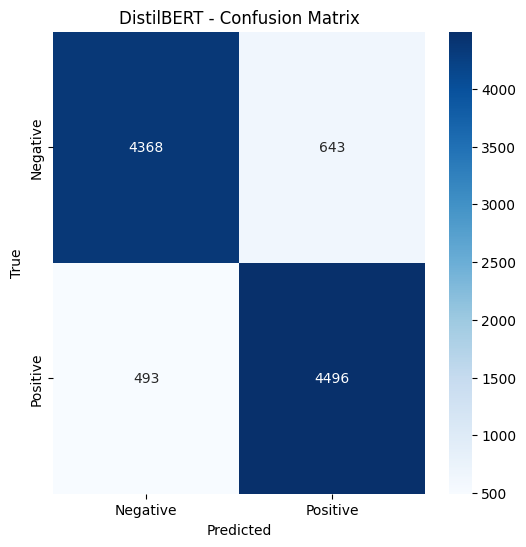

{'0': {'precision': 0.8985805389837482, 'recall': 0.8716822989423268, 'f1-score': 0.8849270664505673, 'support': 5011.0}, '1': {'precision': 0.8748783810079782, 'recall': 0.9011826017237924, 'f1-score': 0.8878357030015798, 'support': 4989.0}, 'accuracy': 0.8864, 'macro avg': {'precision': 0.8867294599958633, 'recall': 0.8864324503330596, 'f1-score': 0.8863813847260735, 'support': 10000.0}, 'weighted avg': {'precision': 0.8867555323696366, 'recall': 0.8864, 'f1-score': 0.8863781852258675, 'support': 10000.0}}


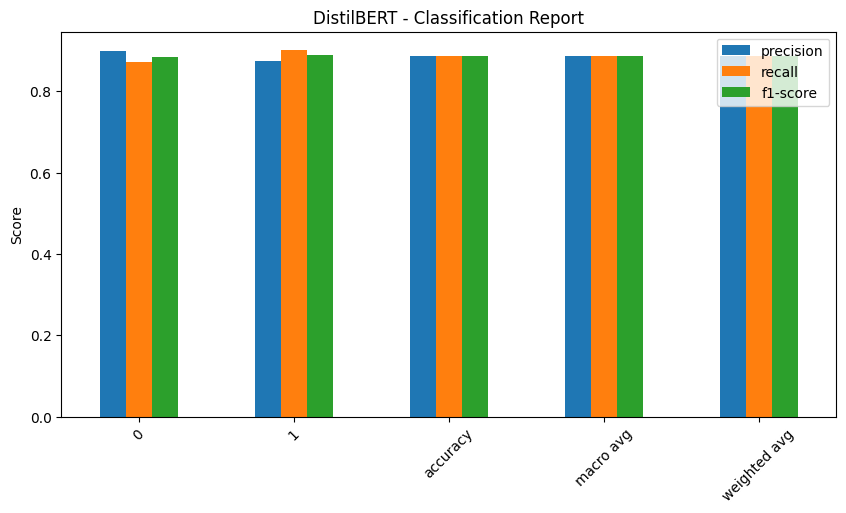

In [ ]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_classification_report(report_dict, model_name):

    metrics = ['precision', 'recall', 'f1-score']
    report_df = pd.DataFrame(report_dict).transpose()

    if all(metric in report_df.columns for metric in metrics):
        plt.figure(figsize=(10, 5))
        report_df[metrics].plot(kind='bar', title=f"{model_name} - Classification Report", ax=plt.gca())
        plt.xticks(rotation=45)
        plt.ylabel('Score')
        plt.show()
    else:
        print("Gerekli metrikler bulunamadı: precision, recall, f1-score")

conf_matrix = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(conf_matrix, "DistilBERT")

report_dict = classification_report(true_labels, pred_labels, output_dict=True)
print(report_dict)
plot_classification_report(report_dict, "DistilBERT")


**16- T5-SMALL Modeli ile Metin Özeti Oluşturma ve Yeni Veri Seti Oluşturma**

In [ ]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def summarize_text(text, max_length=50, min_length=25, length_penalty=1.5):

    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    input_text = "summarize: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(
        inputs,
        max_length=max_length,
        min_length=min_length,
        length_penalty=length_penalty,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

original_texts = []
summaries = []
labels = []

for i, row in final_data.head(1000).iterrows():
    try:
        original_text = row['text']
        label = row['label']

        summary = summarize_text(original_text)

        original_texts.append(original_text)
        summaries.append(summary)
        labels.append(label)
    except Exception as e:
        print(f"Error processing row {i}: {e}")
        original_texts.append(row.get('text', ""))
        summaries.append("")
        labels.append(row.get('label', ""))

output_data = pd.DataFrame({
    'original_text': original_texts,
    'summary': summaries,
    'label': labels
})

output_path = "imdb_summary_first1000.csv"
output_data.to_csv(output_path, index=False)

print(f"İlk 1000 satırın özetlenmiş veri seti kaydedildi: {output_path}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

İlk 1000 satırın özetlenmiş veri seti kaydedildi: imdb_summary_first1000.csv
